In [182]:
using ReactiveMP, GraphPPL, Rocket, Distributions
using Random
using  BenchmarkTools

In [183]:
@model function filtering(Q::ConstVariable, R::ConstVariable)
    A = datavar(Vector{Float64})
    B = constvar([ .0 .0 .0 .0; .0 .0 .0 .0; .0 .0 1. .0; .0 .0 .0 1. ]) 
    prior_m1=[ 0.0, 0.0, 1/8π, 0.01 ]
    prior_m2=[ 0.0, 0.0, -1/8π, 0.01 ]
    prior_m3=[ 0.0, 0.0, 0.0, 0.01 ]
    prior_w1=[1.0 0.0 0.0 0.0; 0.0 1.0 0.0 0.0; 0.0 0.0 1/16π .0; 0.0 0.0 0.0 0.05]
    prior_w2=[1.0 0.0 0.0 0.0; 0.0 1.0 0.0 0.0; 0.0 0.0 1/16π .0; 0.0 0.0 0.0 0.05]
    prior_w3=[1.0 0.0 0.0 0.0; 0.0 1.0 0.0 0.0; 0.0 0.0 1/16π .0; 0.0 0.0 0.0 0.05]

    nmixtures=3

    m = randomvar(nmixtures)
    w = randomvar(nmixtures)

    mean_mean_cov       = [ 1e-6 0.0 0.0 0.0; 0.0 1e-6 0.0 0.0; 0.0 0.0 1e-1 0.0; 0.0 0.0 0.0 1e-1 ]

    m[1] ~ MvNormalMeanCovariance(prior_m1, mean_mean_cov)
    m[2] ~ MvNormalMeanCovariance(prior_m2, mean_mean_cov)
    m[3] ~ MvNormalMeanCovariance(prior_m3, mean_mean_cov)
    w[1] ~ Wishart(6, prior_w1)
    w[2] ~ Wishart(6, prior_w2)
    w[3] ~ Wishart(6, prior_w3)

    means = tuple(m...)
    precs = tuple(w...)
    # control ~ NormalMixture(intent, means, precs)

    x_k_mean = datavar(Vector{Float64})
    x_k_cov  = datavar(Matrix{Float64})
    
    #control depends on intent, and intent is a category Distributions.
    #control is GMM Distributions

    intent ~ Categorical([1/3,1/3,1/3]) where { q = MeanField() }
    println(intent)
    # println((m1, m2))
    control = randomvar()
    control ~ NormalMixture(intent, means, precs) where { q = MeanField() }

    # control ~ MvNormalMeanCovariance(control_mean,  control_covariance)
    x_k ~ MvNormalMeanCovariance(x_k_mean, x_k_cov)
    
    tmp1 ~ (A + x_k) 
    tmp2 ~ (B * control)

    x_k_p_one ~ MvNormalMeanCovariance(tmp1 + tmp2, Q)

    # own ship state
    o_x_k_p_one=datavar(Vector{Float64})
    
    # relative observation between two ships
    y_k = datavar(Vector{Float64})
    
    y_k ~ MvNormalMeanCovariance(x_k_p_one-o_x_k_p_one, R)
    
    return x_k_mean, x_k_cov, x_k_p_one, y_k, A, control, intent, m, w,o_x_k_p_one
end

filtering (generic function with 1 method)

In [184]:
function  own_ship_moving(X,δt,mode)
#    This function can be change to get the state of own ship
    if mode=="head-on"
        c=[0.0 ;0.0 ;-0.0005 ;0.00001]
        qq=diageye(4)*tiny
        o_p=rand(rng,MvNormal(X+[X[4]*cos(X[3])*δt,X[4]*sin(X[3])*δt,0,0]+c*δt,qq))
    end
    
    if mode=="overtaking"
        c=[0.0 ;0.0 ;0.000005 ;0.000000]
        qq=diageye(4)*tiny
        o_p=rand(rng,MvNormal(X+[X[4]*cos(X[3])*δt,X[4]*sin(X[3])*δt,0,0]+c*δt,qq))
    end

    if mode=="crossing"
        c=[0.0 ;0.0 ;0.0005 ;0.0000001]
        qq=diageye(4)*tiny
        o_p=rand(rng,MvNormal(X+[X[4]*cos(X[3])*δt,X[4]*sin(X[3])*δt,0,0]+c*δt,qq))
    end
    return o_p
end

own_ship_moving (generic function with 1 method)

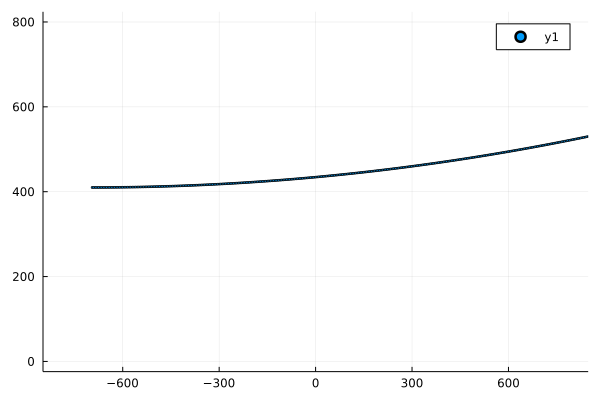

In [185]:
using Plots
slicedim(dim) = (a) -> map(e -> e[dim], a)
rng= MersenneTwister(1234)
# X=[0.0;800.0 ;-π/2;5.0]
# X=[-20.0;100.0;π/2.00001;1.0]
X=[-700.0;410.0;0.00001;5.0]
o_w=[]
for i = 1:500
    X=own_ship_moving(X,1.0,"crossing")
    # println(X)
    push!(o_w,X)
end
o_w
px = plot()
# px = plot!(px, o_w |> slicedim(1), label = "Hidden Signal (dim-1)", color = :orange)
p1 = scatter(map(o -> o[1], o_w), map(o -> o[2], o_w),  ms = 2, xlims=[-800, 800],ylims=[0, 800])

# plot(o_w, label = "c[3]")


In [186]:
o_w[:][1]

4-element Vector{Float64}:
 -694.9999991329028
  410.00004909825617
    0.0005095055212464958
    4.999999197085707

In [187]:
function getAFromState(x,δt)
    A=zeros(4)
    A[1]=x[4]*cos(x[3])*δt
    A[2]=x[4]*sin(x[3])*δt
    return A
end

getAFromState (generic function with 1 method)

In [188]:
function generateNewObservation(ii, δt, observation, actual_control,mode)
    
    # 1.0 simulate true action
    
    # 2.0 update your observation

    q=diageye(4)*0.00000001
    if mode=="head-on"
        if ii<100
            c_m=zeros(4)
            c_m[3]=0.0
            c_m[4]=0.00
            actual_control=c_m
        end
        if ii>=100 && ii<250
            c_m=zeros(4)
            c_m[3]=-1/80π
            c_m[4]=0.00
            actual_control=c_m
        end
        if ii>=250 && ii<380
            c_m=zeros(4)
            c_m[3]=1/100π
            c_m[4]=0.001
            actual_control=c_m
        end

        if ii>=380
            c_m=zeros(4)
            c_m[3]=1/2000π
            c_m[4]=0.00
            actual_control=c_m
        end
    end
    if mode =="overtaking"
        if ii<100
            c_m=zeros(4)
            c_m[3]=0.00
            c_m[4]=0.00
            actual_control=c_m
            
        end
        if ii>=100 && ii<200
            c_m=zeros(4)
            c_m[3]=1/80π
            c_m[4]=0.01
            actual_control=c_m
        end
        if ii>=200 && ii<300
            c_m=zeros(4)
            c_m[3]=-1/100π
            c_m[4]=0.00
            actual_control=c_m
        end
        if ii>=300
            c_m=zeros(4)
            c_m[3]=0.0
            c_m[4]=0.00
            actual_control=c_m
        end
    end
    if mode =="crossing"
        if ii < 100
            c_m=zeros(4)
            c_m[3]=0.0
            c_m[4]=0.00
            actual_control=c_m
        end
        if ii >= 100 && ii<200
            c_m=zeros(4)
            c_m[3]=1/50π
            c_m[4]=0.00
            actual_control=c_m
    
        end
        if ii >= 200 && ii<310
            c_m=zeros(4)
            c_m[3]=-1/60π
            c_m[4]=0.00
            actual_control=c_m
    
        end
        if ii >= 310 
            c_m=zeros(4)
            c_m[3]=0.0
            c_m[4]=0.00
            actual_control=c_m
    
        end
    end
        

   
    #

    x=observation
    μ=actual_control
    x_0=rand(rng,MvNormal(x+[x[4]*cos(x[3])*δt,x[4]*sin(x[3])*δt,0,0]+μ*δt,q))
    return x_0
end

generateNewObservation (generic function with 1 method)

In [189]:
function inference(δt, max_data_points, max_vmp_iterations,mode)
    
    data_stream1 = ReplaySubject(Vector{Float64}, 1)
    data_stream2 = ReplaySubject(Vector{Float64}, 1)

    saved_controls = []
    saved_position = []
    saved_observations = []
    saved_intent   = []
    saved_own_position=[]
    ii = 0

    # y_current = zeros(4)
    # y_current = [0.0,0.0,0,1.0]
    
    # TODO: Depend on δt
    Q = diageye(4)*0.01
    R = diageye(4)*0.01
    
    model, (x_k_mean, x_k_cov, x_k_p_one, y_k, A, control, intent, m, w, o_x_k_p_one) = filtering(Q, R)
    # ** setmarginal

    setmarginal!(m[1], MvNormalMeanCovariance(ones(4), diageye(4)))
    setmarginal!(m[2], MvNormalMeanCovariance(zeros(4), diageye(4)))
    setmarginal!(m[3], MvNormalMeanCovariance(zeros(4), diageye(4)))

    setmarginal!(w[1], Wishart(5, diageye(4)))
    setmarginal!(w[2], Wishart(5, diageye(4)))
    setmarginal!(w[3], Wishart(5, diageye(4)))

    setmarginal!(intent, vague(Categorical, 3))
    setmarginal!(control, vague(MvNormalMeanCovariance, 4))
    setmarginal!(x_k_p_one, vague(MvNormalMeanCovariance, 4))

    

    stream = combineLatest(
        (
        getmarginal(x_k_p_one, IncludeAll()), 
        getmarginal(control, IncludeAll()), 
        getmarginal(intent, IncludeAll()), 
        data_stream1,
        data_stream2
        ), PushNew()
    )


    fe_actor = ScoreActor(Float64)

    fe_subscription = subscribe!(score(Float64, BetheFreeEnergy(), model), fe_actor)

    finish = Condition()
    
    subscription = subscribe!(stream |> async() |> take(max_data_points) |> tap_on_complete(() -> notify(finish)), (d) -> begin

        x_k_p_one_posterior = d[1]
        control_posterior   = d[2] 
        intent_posterior    = d[3]
        data_point1         = d[4]
        data_point2         = d[5]

        push!(saved_observations, data_point1)

        μ, Σ = mean_cov(x_k_p_one_posterior)
        pA = getAFromState(μ, δt)
        
        for k in 1:max_vmp_iterations
            update!(x_k_mean, μ)
                
            update!(x_k_cov, Σ)
                
            # Update A here
            update!(A, pA)

            update!(o_x_k_p_one, data_point2)
            update!(y_k, data_point1)
            # update!(intent, mean(intent_posterior))
        end

        release!(fe_actor)

        index = length(saved_controls)
        ii = ii + 1

        # Save our result

        push!(saved_controls, Rocket.getrecent(getmarginal(control, IncludeAll())))   
        push!(saved_position, Rocket.getrecent(getmarginal(x_k_p_one, IncludeAll())))  
        push!(saved_intent, Rocket.getrecent(getmarginal(intent, IncludeAll())))  
            
        # update y_current somehow

        #true action
        
        c_m=zeros(4)
        c_m[3]=0.0
        c_m[4]=0.0


        y_own=own_ship_moving(data_point2,δt,mode)
        push!(saved_own_position,y_own)
        next!(data_stream2, y_own)
        
        y_next = generateNewObservation(ii, δt, data_point1+data_point2, c_m,mode)  

        y_relative=y_next-y_own


        
            
        next!(data_stream1, y_relative)

    end)

    # Start to initial
    if mode=="head-on"
        y_initial=[10.0;10.0 ;π/2.001;1.0]
        y_own_initial=[0.0;800.0 ;-π/2;1.0]
    end
    if mode=="overtaking"
        y_initial=[10.0;10.0 ;π/2.001;0.8]
        y_own_initial=[-20.0;100.0;π/2.00001;1.0]
    end

    if mode=="crossing"
        y_initial=[-10.0;10.0 ;π/2.001;2.0]
        y_own_initial=[-700.0;410.0;0.00001;5.0]
    end
    next!(data_stream2, y_own_initial) # Initial state
    next!(data_stream1, y_initial-y_own_initial) # Initial state

    
    wait(finish)

    # unsubscribe!(subscription)
    
    return saved_controls, saved_observations, saved_position, saved_intent, getvalues(fe_actor),saved_own_position
end

inference (generic function with 1 method)

In [190]:
δt = 1

1

In [191]:
rng= MersenneTwister(1234)
mode="overtaking"
controls, obs, pos,intents, fe ,own_ship= inference(δt, 500, 25,mode);

RandomVariable(intent)


In [192]:
obs

500-element Vector{Any}:
 [30.0, -90.0, -0.0007771517182029175, -0.19999999999999996]
 [30.009263296306926, -90.17788056972314, 0.004546475582245968, -0.2027164510460523]
 [30.006917945915376, -90.36207690214724, -0.0037355982345850247, -0.20161547049104878]
 [30.025542532888128, -90.57766566335953, 0.007314308040121009, -0.21268126619684713]
 [30.016686906785466, -90.79639502019833, -0.005487565037680442, -0.2027088639185326]
 [30.030031532128184, -91.00425110162503, -0.013140692060704673, -0.2181236490306615]
 [30.026694812376405, -91.22358556760737, -0.011486741869002337, -0.2222077139153419]
 [30.028769612674218, -91.45297318311437, -0.014761104105143863, -0.21705881053013087]
 [30.02978139662928, -91.67998846474393, 5.4374271203805336e-5, -0.2222864820810594]
 [30.033415289757905, -91.89605834846287, 0.0018748068422760333, -0.2016507611439291]
 ⋮
 [-161.87418345732928, 221.14892132770376, 0.3570227356503184, 1.338166705534554]
 [-162.7135209026051, 222.3393111514455, 0.34529054235

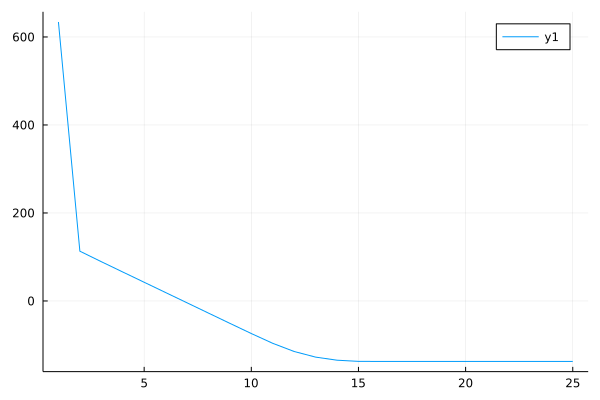

In [193]:

plot(fe)

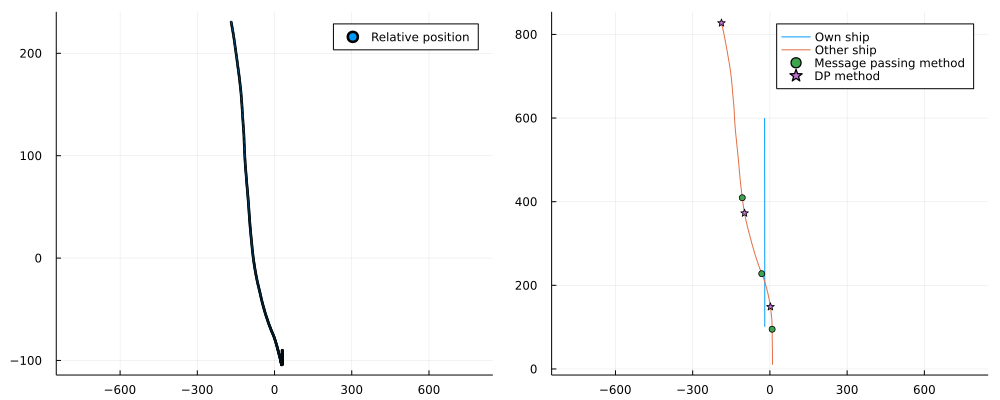

In [194]:
p1 = scatter(map(o -> o[1], obs), map(o -> o[2], obs),  ms = 2, label="Relative position",xlim=[-800,800])
# p1 = scatter(map(o -> o[1], mean.(pos)), map(o -> o[2], mean.(pos)),  ms = 2)
p2=plot(map(o -> o[1],own_ship), map(o -> o[2],own_ship),label="Own ship",xlim=[-800,800])
p2 = plot!(map(o -> o[1], mean.(pos)), map(o -> o[2], mean.(pos)),  ms = 2,label="Other ship")
if mode=="head-on"
    indexofown=[100, 250, 380]
    indexofcompare=[158,338,498]
end
if mode=="overtaking"
    indexofown=[100, 200, 300]
    indexofcompare=[148,281,499]
end
if mode=="crossing"
    indexofown=[100, 200, 310]
    indexofcompare=[112,140,165,500]
end

p2=scatter!(map(o -> o[1], mean.(pos))[indexofown], map(o -> o[2], mean.(pos)[indexofown]),label="Message passing method")
p2=scatter!(map(o -> o[1], mean.(pos))[indexofcompare], map(o -> o[2], mean.(pos)[indexofcompare]),shape=:star5,label="DP method")

# p2 = plot(map(o -> o[1], obs))
# p3 = plot(map(o -> o[2], obs))

plot(p1, p2, layout = @layout([ a b ]), size = (1000, 400))


# ff=mean.(pos)
# f=open("other_ship_crossing.csv","w")
# nf=length(ff)
# for i= 1: nf
#     write(f,string(i))
#     write(f,",")
#     for j=1:4
#         write(f,string(ff[i][j]))
#         write(f,",")
#     end
#     write(f,"\n")
# end
# close(f)

In [195]:
mean.(controls)

500-element Vector{Vector{Float64}}:
 [6.551990859709492e-35, 6.551990859709492e-35, 1.3596450493810853e-11, 0.010000000002630306]
 [-2.78588784575056e-105, -2.7858878457505364e-105, 0.005308173083166271, -0.0025991640807665048]
 [-1.6400588189490188e-182, -1.6400588189490278e-182, -0.008240009988156464, 0.0011445490502221768]
 [-1.8204117448244835e-259, -1.8204117448244578e-259, 0.01100329341141853, -0.0108991448542092]
 [0.0, 0.0, -0.012735064354841858, 0.009908677604005909]
 [0.0, 0.0, -0.007635249402990901, -0.015178602861076114]
 [0.0, 0.0, 0.0016426257540946433, -0.00403162121758655]
 [0.0, 0.0, -0.003256290917518016, 0.005149935854421936]
 [0.0, 0.0, 0.014762157064782237, -0.005101372870214588]
 [0.0, 0.0, 0.0018374763460651188, 0.020489804047309303]
 ⋮
 [0.0, 0.0, 0.003216460427231529, 0.014927101566899938]
 [0.0, 0.0, -0.01167910849110184, 2.2124260024918803e-5]
 [0.0, 0.0, 0.0023726202174345675, -0.0245671904991602]
 [0.0, 0.0, -0.003623212229120151, -0.01056487536243611]
 [0

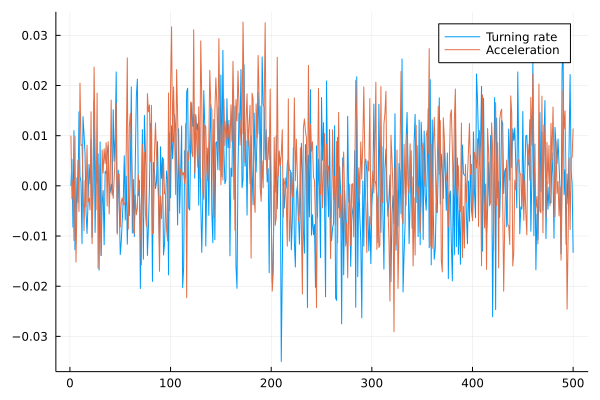

In [196]:
plot(map(c -> c[3] / δt, mean.(controls)), label = "Turning rate")
# plot(map(c -> c[3] / δt, mean.(controls)), ribbon = map(c -> c[3] / δt, var.(controls)), label = "c[3]")
plot!(map(c -> c[4] / δt, mean.(controls)), label = "Acceleration")
# plot!(map(c -> c[3] / δt, var.(controls)), label = "c[3]")
# plot!(map(c -> c[4] / δt, var.(controls)), label = "c[4]v")

In [197]:
1/16π

0.019894367886486918

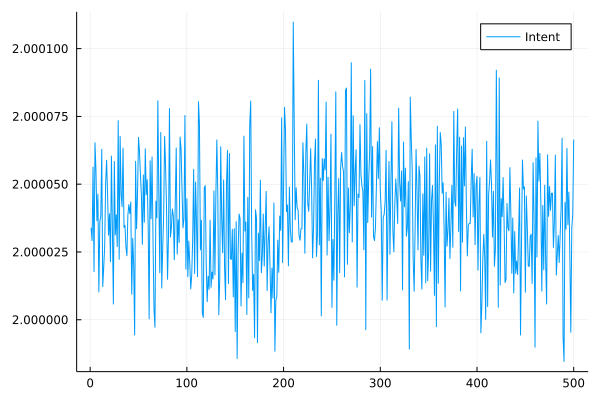

In [198]:
plot(mean.(intents),label = "Intent")
# println(var.(intents))

In [199]:
cov.(controls)[2]

4×4 Matrix{Float64}:
  0.166667       1.16716e-59   -3.68266e-108   4.36416e-107
  1.16716e-59    0.166667      -3.68266e-108   4.36416e-107
 -3.68266e-108  -3.68266e-108   0.0298871     -1.22514e-10
  4.36416e-107   4.36416e-107  -1.22514e-10    0.0297183